In [1]:
# !pip install pytorch-lightning pycocotools
# !export CUDA_VISIBLE_DEVICES=3
!pip install -e .
# !pip install timm

import os, threading 
print(os.getpid(), threading.current_thread().ident)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Obtaining file:///mnt/essd/bslei/CIS680/Final/segment-anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment-anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment-anything
3597261 140082698559872


In [9]:
import glob
import os
import torch
import torchvision
import torchvision.transforms as transforms
import cv2

from PIL import Image

from pycocotools import mask as mask_utils

import json
import numpy as np
from tqdm import tqdm

def get_bbox_from_mask(target):
    bbox = []
    valid_index = []
    for idx, mask in enumerate(target):
        if mask.sum() > 0.:
            coord_y, coord_x = torch.where(mask > 0)
            if len(coord_x) == 0:
                import pdb; pdb.set_trace()
            x1, y1 = coord_x.min(), coord_y.min()
            x2, y2 = coord_x.max(), coord_y.max()
            bbox.append(torch.stack([x1, y1, x2, y2])) # (Image Coordinate)
            valid_index.append(idx)

    return torch.stack(bbox), valid_index

input_transforms = transforms.Compose([
    transforms.Resize((160, 256)),
    transforms.ToTensor(),
])

target_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((160, 256)),
])

class SA1B_Dataset(torchvision.datasets.ImageFolder):
    """A data loader for the SA-1B Dataset from "Segment Anything" (SAM)
    This class inherits from :class:`~torchvision.datasets.ImageFolder` so
    the same methods can be overridden to customize the dataset.
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, _ = self.imgs[index] # discard automatic subfolder labels
        image = self.loader(path)
        masks = json.load(open(f'{path[:-3]}json'))['annotations'] # load json masks
        target = []

        for m in masks:
            # decode masks from COCO RLE format
            target.append(mask_utils.decode(m['segmentation']))
        target = np.stack(target, axis=-1)

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        target[target > 0] = 1 # convert to binary masks

        return image, target

    def __len__(self):
        return len(self.imgs)


input_reverse_transforms = transforms.Compose([
    transforms.ToPILImage(),
])

import matplotlib.pyplot as plt
def show_image(image, target, row=12, col=12):
    # image: numpy image
    # target: mask [N, H, W]
    bbox, vidx = get_bbox_from_mask(target)
    target = target[vidx]
    fig, axs = plt.subplots(row, col, figsize=(20, 12))
    for i in range(row):
        for j in range(col):
            if i*row+j < target.shape[0]:
                box = bbox[i*row+j]
                canvas = image.copy()
                cv2.rectangle(canvas, (box[0].item(), box[1].item()),
                                (box[2].item(), box[3].item()), (255, 0, 0))
                axs[i, j].imshow(canvas)
                axs[i, j].imshow(target[i*row+j], alpha=0.5)
            else:
                axs[i, j].imshow(image)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()


torch.Size([3, 160, 256]) torch.Size([89, 160, 256])


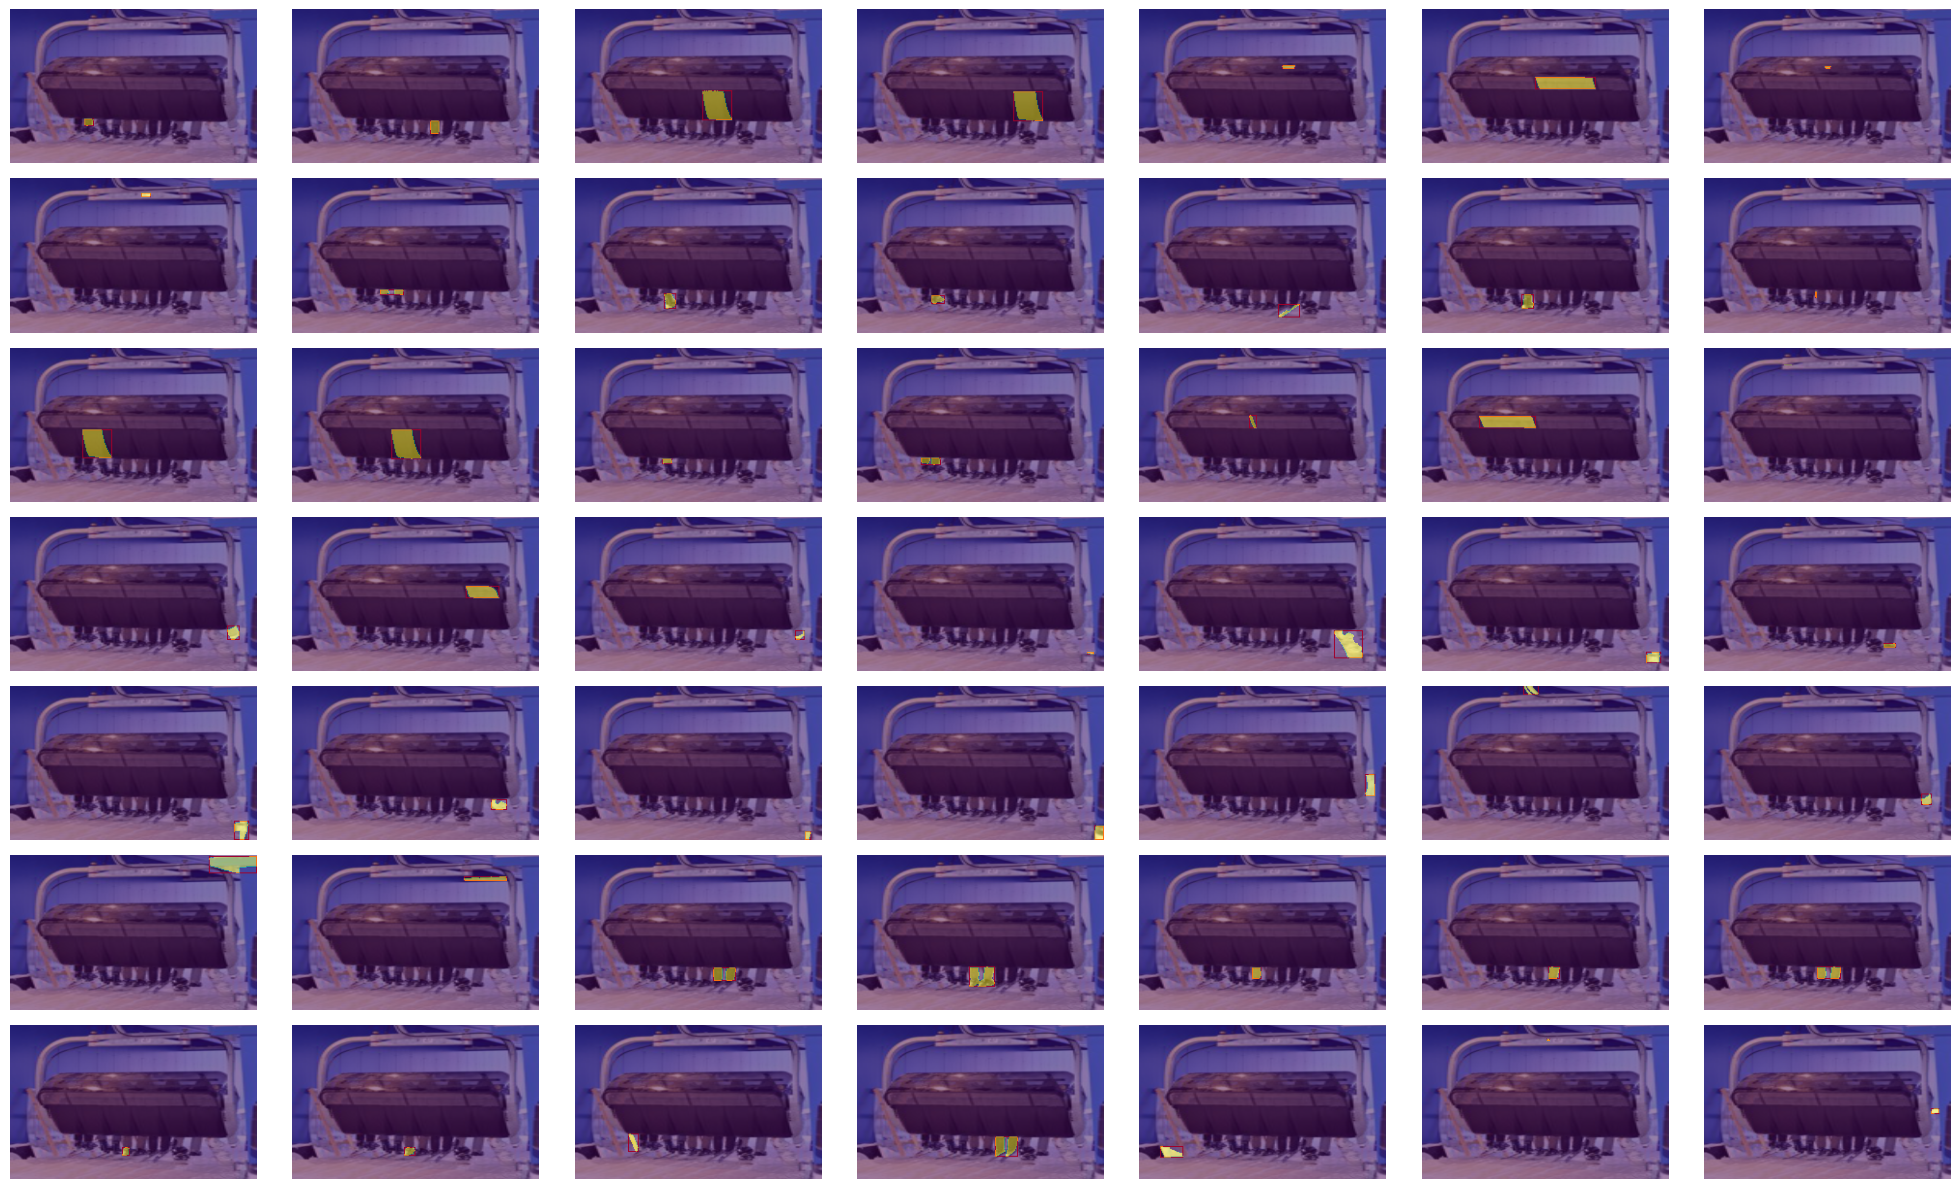

In [10]:
path = './sa1b'
dataset = SA1B_Dataset(path, transform=input_transforms, target_transform=target_transforms)
image, target = dataset.__getitem__(8820)
print(image.shape, target.shape)

image = input_reverse_transforms(image)
image = np.array(image)
show_image(image, target, 7, 7)

In [11]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# you may want to make a local copy instead of pip install,
# as you may need to modify their code
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [12]:
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")

print(sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [13]:
# SAM on Low resolution images

from segment_anything import SamPredictor

sam.cuda()
predictor = SamPredictor(sam)

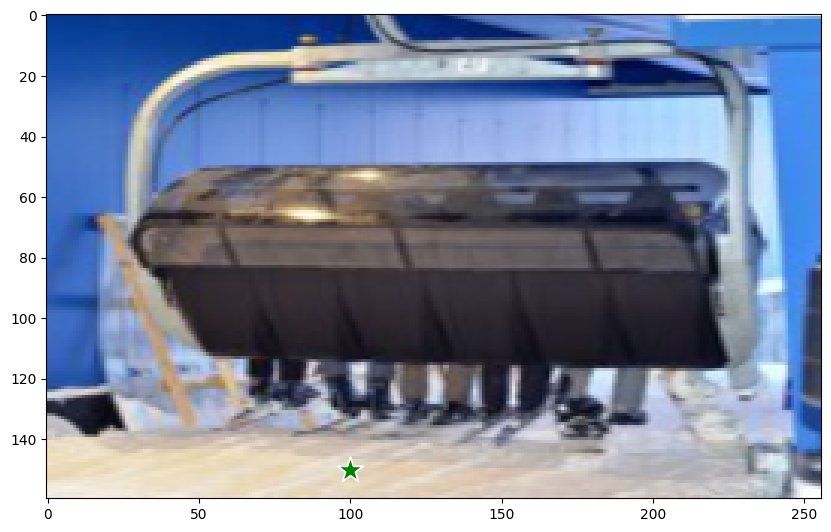

In [14]:
# SAM Official Prediction Demo
predictor.set_image(image)

# set the click point
input_point = np.array([[100, 150]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

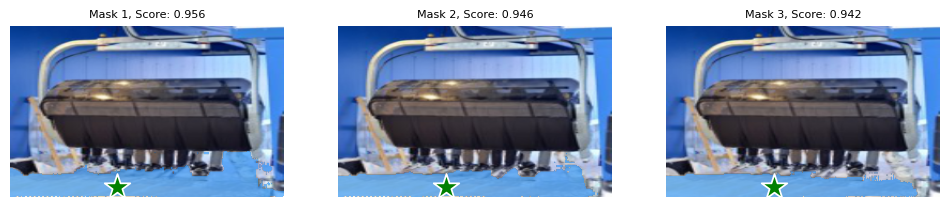

In [15]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (mask, score) in enumerate(zip(masks, scores)):
    axes[i].imshow(image)
    show_mask(mask, axes[i])
    show_points(input_point, input_label, axes[i])
    axes[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=8)
    axes[i].axis('off')
fig.show()

tensor([ 77, 114,  86, 121], device='cuda:0')
tensor([308., 456., 344., 484.], device='cuda:0')


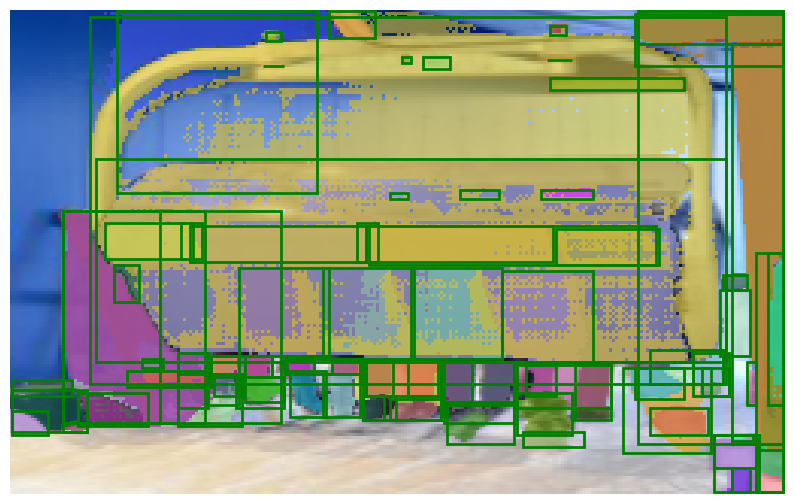

In [16]:
input_boxes, vidx = get_bbox_from_mask(target)
target = target[vidx]
input_boxes = input_boxes.to(predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
print(input_boxes[0])
print(transformed_boxes[0])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

def create_sampled_grid(scales, orig_shape):
    y_scale, x_scale = scales
    y_shape, x_shape = orig_shape

    sampled_coord = torch.meshgrid(torch.arange(0, y_shape, y_scale).float(), 
            torch.arange(0, x_shape, x_scale).float())
    
    sampled_coord = torch.stack(sampled_coord, dim=-1)
    print(sampled_coord[..., 0], sampled_coord[..., 1])
    sampled_coord[..., 0] = (sampled_coord[..., 0] - y_shape / 2) / y_shape / 2
    sampled_coord[..., 1] = (sampled_coord[..., 1] - x_shape / 2) / x_shape / 2

    return sampled_coord

# Copy SAM Model
downsampled_sam = deepcopy(sam)

# Hack Patchfy Model
print(sam.image_encoder.patch_embed.proj)

# Since SAM Resolution is 1024 x 1024 \ Current input resolution is 160 x 256
# Y axis - Downsample 6.4 \ X axis - Downsample 4

# print(sam.image_encoder.patch_embed.proj.weight.data.shape)
print(sam.image_encoder.patch_embed.proj.bias.data.shape)
filter_shape = sam.image_encoder.patch_embed.proj.weight.data.shape[-2:]
print(filter_shape)

# # Coordinate Sampling
# sampled_coord = create_sampled_grid((4, 4), filter_shape)

# downsampled_cnn = nn.Conv2d(3, 768, (4, 4), stride=(4, 4), padding=(0, 0))
# downsampled_cnn.cuda()
# sampled_coord = sampled_coord.cuda().unsqueeze(0)
# sampled_coord = sampled_coord.repeat((768, 1, 1, 1))

# downsampled_cnn_weight = F.grid_sample(sam.image_encoder.patch_embed.proj.weight.data, sampled_coord)
# downsampled_cnn.weight.data.copy_(downsampled_cnn_weight)
# downsampled_cnn.bias.data.copy_(sam.image_encoder.patch_embed.proj.bias.data)

# # Assign the new patchfy model
# downsampled_sam.image_encoder.patch_embed.proj = downsampled_cnn

# hack SAM PE module
print(sam.image_encoder.pos_embed.shape)
_, H, W, _ = sam.image_encoder.pos_embed.shape
pos_embed_feature = sam.image_encoder.pos_embed.data[:, :H//4, :W//4, :]
# sampled_coord = create_sampled_grid((6.4, 4), pos_embed_feature.shape[-2:])
# sampled_coord = sampled_coord.cuda().unsqueeze(0)
# sampled_coord = sampled_coord.repeat((768, 1, 1, 1))
# downsampled_pos_embed = F.grid_sample(pos_embed_feature, sampled_coord)
# downsampled_pos_embed = downsampled_pos_embed.permute(0, 2, 3, 1)

del downsampled_sam.image_encoder.pos_embed
downsampled_sam.image_encoder.pos_embed = nn.Parameter(pos_embed_feature)

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
torch.Size([768])
torch.Size([16, 16])
torch.Size([1, 64, 64, 768])


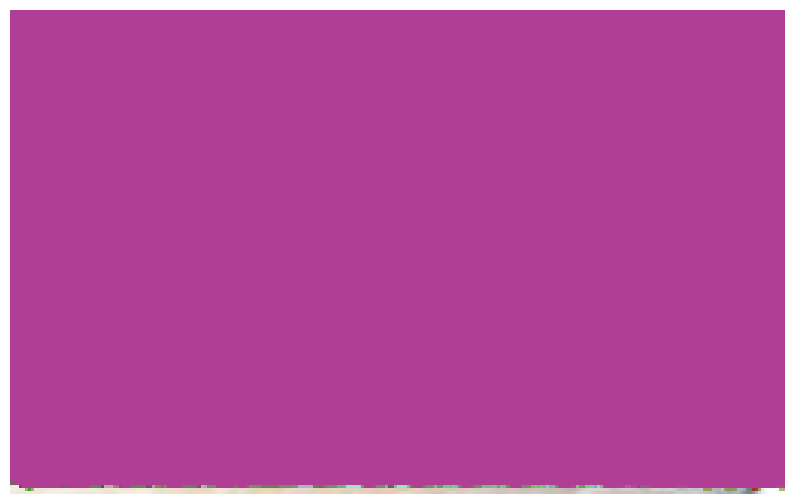

In [22]:
# Test on low resolution
downsampled_sam.image_encoder.img_size = 256
downsampled_sam.prompt_encoder.factor = 4
downsampled_sam.prompt_encoder.image_embedding_size = (16, 16)

predictor = SamPredictor(downsampled_sam)

bbox, vidx = get_bbox_from_mask(target)
target = target[vidx]

pts = []
for mask in target:
    points_y, points_x = torch.where(mask > 0)
    chosen_index = torch.arange(len(points_x))[:4]
    pts.append(torch.stack([points_x[chosen_index], points_y[chosen_index]], dim = 1)) # (N, 2)
pts = torch.stack(pts, dim=0).cuda() # (B, N, 2)

updated_batch = []
updated_batch.append(
    {
        "image": torch.from_numpy(image).cuda().permute(2, 0, 1),
        "point_coords":pts,
        "point_labels": torch.ones(*pts.shape[:2], device=pts.device),
        "original_size": (160, 256)
    }
)

# predictor.set_image(image)
# masks_low, scores, logits = predictor.predict_torch(
#     point_coords=pts,
#     point_labels=torch.ones(*pts.shape[:2], device=pts.device),
#     boxes=None,
#     multimask_output=False,
# )

pred = downsampled_sam(updated_batch, multimask_output=False)
masks = pred[0]["masks"]

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()
        

In [19]:
def calculateIoU(pred, gt):
    pred = pred.squeeze(1).cpu()
    
    intersect = (pred * gt).sum(dim=(-1, -2))
    union = pred.sum(dim=(-1, -2)) + gt.sum(dim=(-1, -2)) - intersect
    ious = intersect.div(union)
    return ious

ious = calculateIoU(masks_low, target)
print(ious.mean())

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
axes[0].imshow(image)
axes[1].imshow(image)
axes[2].imshow(image)

show_mask(masks[28].cpu().numpy(), axes[0], random_color=True)
show_mask(masks_low[28].cpu().numpy(), axes[1], random_color=True)
show_mask(target[28].cpu().numpy(), axes[2], random_color=True)

axes[0].set_title(" Full resolution ")
axes[1].set_title(" Low resolution ")
axes[2].set_title(" Ground Truth ")

# show_box(input_boxes[0].cpu().numpy(), axes[0])
# show_box(input_boxes[0].cpu().numpy(), axes[1])

# fig.axis('off')
fig.show()

NameError: name 'masks_low' is not defined

In [ ]:
from tqdm import tqdm

def test(sam, dataset, test_idx):
    predictor = SamPredictor(sam)
    ious_all = torch.tensor([])
    for t_idx in tqdm(test_idx):
        image, target = dataset[t_idx]
        image = input_reverse_transforms(image)
        image = np.array(image)

        assert len(target) > 0, "zero targets"

        bbox, vidx = get_bbox_from_mask(target)
        target = target[vidx]
        bbox = bbox.to(predictor.device)
        transformed_boxes = predictor.transform.apply_boxes_torch(bbox, image.shape[:2])

        predictor.set_image(image)
        masks, scores, logits = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

        ious = calculateIoU(masks, target)
        ious_all = torch.cat([ious_all, ious])

    print("Average mIoUs: {:.2f}".format(ious_all.mean()))
    return ious_all

# print("test original sam")
# test(sam, dataset, list(range(20)))
# print("test low sam")
# test(downsampled_sam, dataset, list(range(20)))


In [ ]:
# LoRA Module
from torch import nn


class LoRALinearLayer(nn.Module):
    def __init__(self, in_features, out_features, rank=4):
        super().__init__()

        if rank > min(in_features, out_features):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(in_features, out_features)}"
            )

        self.down = nn.Linear(in_features, rank, bias=False)
        self.up = nn.Linear(rank, out_features, bias=False)

        nn.init.normal_(self.down.weight, std=1 / rank)
        nn.init.zeros_(self.up.weight)

    def forward(self, hidden_states):
        orig_dtype = hidden_states.dtype
        dtype = self.down.weight.dtype

        down_hidden_states = self.down(hidden_states.to(dtype))
        up_hidden_states = self.up(down_hidden_states)

        return up_hidden_states.to(orig_dtype)

    @property
    def weight(self):
        return self.up.weight @ self.down.weight

    @property
    def bias(self):
        return 0

class MonkeyPatchLoRALinear(nn.Module):
    # It's "monkey patch" means you can replace nn.Linear with the new
    # LoRA Linear class without modifying any other code.
    def __init__(self, fc: nn.Linear, rank=4, lora_scale=1):
        super().__init__()
        if rank > min(fc.in_features, fc.out_features):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(fc.in_features, fc.out_features)}"
            )
        if not isinstance(fc, nn.Linear):
            raise ValueError(
                f"MonkeyPatchLoRALinear only support nn.Linear, but got {type(fc)}"
            )

        self.fc = fc
        self.rank = rank
        self.lora_scale = lora_scale

        in_features = fc.in_features
        out_features = fc.out_features
        self.fc_lora = LoRALinearLayer(in_features, out_features, rank)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc(hidden_states) + \
                        self.lora_scale * self.fc_lora(hidden_states)
        return hidden_states

    @property
    def weight(self):
        return self.fc.weight + self.lora_scale * self.fc_lora.weight

    @property
    def bias(self):
        return self.fc.bias

# your implementation

class LoRAConv2DLayer(nn.Module):
    def __init__(self, in_features, out_features, kernel, stride = 1, padding = 0, rank=4):
        super().__init__()

        if rank > min(in_features, out_features):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(in_features, out_features)}"
            )
        
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_size = kernel
        self.rank = rank

        self.down = nn.Conv2d(in_features, rank, 1, 1, 0, bias=False)
        self.up = nn.Conv2d(rank, out_features, kernel, stride, padding, bias=False)

        nn.init.normal_(self.down.weight, std = 1 / rank)
        nn.init.zeros_(self.up.weight)

    def forward(self, hidden_states: torch.Tensor):
        orig_dtype = hidden_states.dtype
        dtype = self.down.weight.dtype

        down_hidden_states = self.down(hidden_states.to(dtype))
        up_hidden_states = self.up(down_hidden_states)

        return up_hidden_states.to(orig_dtype)
    
    @property
    def weight(self):
        composite_weight = torch.einsum('rnjk,mrjk->mnjk', self.up.weight, self.down.weight)
        return composite_weight

    @property
    def bias(self):
        return 0

class MonkeyPatchLoRAConv2D(nn.Module):
    def __init__(self, module: nn.Conv2d, rank=4, lora_scale=1):
        super().__init__()
        if rank > min(module.in_channels, module.out_channels):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(module.in_channels, module.out_channels)}"
            )
        if not isinstance(module, nn.Conv2d):
            raise ValueError(
                f"MonkeyPatchLoRALinear only support nn.Linear, but got {type(module)}"
            )

        self.conv = module
        self.rank = rank
        self.kernel_size = module.kernel_size
        self.stride = module.stride
        self.padding = module.padding
        self.lora_scale = lora_scale

        in_channels = module.in_channels
        out_channels = module.out_channels
        self.conv_lora = LoRAConv2DLayer(in_channels, out_channels, self.kernel_size, self.stride, self.padding, rank)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.conv(hidden_states) + \
                        self.lora_scale * self.conv_lora(hidden_states)
        return hidden_states
    
    @property
    def weight(self):
        return self.conv.weight + self.lora_scale * self.conv_lora.weight

    @property
    def bias(self):
        return self.conv.bias

# class LoRAConvTranspose2DLayer(nn.Module):
#     ...

# class MonkeyPatchLoRAConvTranspose2D(nn.Module):
#     ...

In [ ]:
# remove downsampled SAM
# del downsampled_sam

def print_params(model):
    model_parameters = filter(lambda p: True, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("total params: ", params)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("training params: ", params)

# inject LoRA
LoRA_sam = deepcopy(downsampled_sam)
for param in LoRA_sam.parameters():
    param.requires_grad_(False)

def replace_LoRA(model:nn.Module, cls):
    for name, block in model.named_children():
        # patch every nn.Linear in Mlp
        if isinstance(block, nn.Linear) and cls == MonkeyPatchLoRALinear:
            block = cls(block, 4, 1)
            setattr(model, name, block)

            for param in block.fc.parameters():
                param.requires_grad_(False)
            for param in block.fc_lora.parameters():
                param.requires_grad_(True)
        
        elif isinstance(block, nn.Conv2d) and cls == MonkeyPatchLoRAConv2D:
            min_channel = min(block.in_channels, block.out_channels)
            if min_channel > 4:
                block = cls(block, 4, 1)
                setattr(model, name, block)

                for param in block.conv.parameters():
                    param.requires_grad_(False)
                for param in block.conv_lora.parameters():
                    param.requires_grad_(True)
                    
        else:
            replace_LoRA(block, cls)

replace_LoRA(LoRA_sam, MonkeyPatchLoRALinear)
replace_LoRA(LoRA_sam, MonkeyPatchLoRAConv2D)

print_params(LoRA_sam)

total params:  91501696
training params:  715344


In [ ]:
from torch.optim import Adam
import random
import pdb
from torch.utils.tensorboard import SummaryWriter

def compute_loss(pred, target, alpha = 0.25, gamma = 2):

    total_focal_loss = torch.tensor(0., device="cuda:0")
    total_dice_loss = torch.tensor(0., device="cuda:0")

    for pred_mask, gt_mask in zip(pred, target):
        pred_mask = pred_mask["masks"][:, -1, :, :]
        fl_1 = -alpha * ( (1 - pred_mask[gt_mask > .5]) ** gamma ) * \
            torch.log(pred_mask[gt_mask > .5])
        
        fl_2 = -(1-alpha) * ( (pred_mask[gt_mask < .5]) ** gamma ) * \
            torch.log(1 - pred_mask[gt_mask < .5])
        
        focal_loss = (torch.sum(fl_1) + torch.sum(fl_2)) / pred_mask.numel()
        total_focal_loss += focal_loss
        
        dice_loss = 2 * torch.sum( pred_mask * gt_mask, dim=(-1, -2) ) / \
            ( torch.sum( pred_mask ** 2, dim=(-1, -2) ) + torch.sum( gt_mask ** 2, dim=(-1, -2) ) + 1e-5)
        dice_loss = 1 - dice_loss
        dice_loss = torch.sum(dice_loss)
        total_dice_loss += dice_loss
    
    return total_focal_loss / len(pred) , total_dice_loss / len(pred)

# import datetime

# date = datetime.datetime.now()
# writer_dir = "LoRA-{}-{}-{}:{}:{}".format(date.month, date.day, date.hour, date.minute, date.second)
# summary_writer = SummaryWriter(args.train_dir)

# Main Training Loop
num_epochs = 10
batch_size = 1
lr = 1e-3

class SA1bSubset(SA1B_Dataset):
    def __init__(self, subset_index:np.ndarray, **kwargs):
        super(SA1bSubset, self).__init__(**kwargs)
        self.subset_index = subset_index

        assert np.max(subset_index) < super(SA1bSubset, self).__len__()
    
    def __len__(self):
        return len(self.subset_index)
    
    def __getitem__(self, index):
        # get data in the subset 
        sub_index = self.subset_index[index]
        image, target = super(SA1bSubset, self).__getitem__(sub_index)
        bbox, vidx = get_bbox_from_mask(target)

        while len(vidx) == 0:
            print(" Reloading ... ")
            next_index = random.randint(0, len(self) - 1)
            next_sub_index = self.subset_index[next_index]
            image, target = super(SA1bSubset, self).__getitem__(next_sub_index)
            bbox, vidx = get_bbox_from_mask(target)
        
        target = target[vidx]
        return image, bbox, target


def collate_fn(batches):
    batch_data = []
    targets = []

    for b in batches:
        image, bbox, target = b
        batch_data.append(
            {
                "image": image,
                "boxes": bbox
            }
        )

        targets.append(target)

    return batch_data, targets

def train(model, train_dataset, test_dataset):
    model.cuda()
    optimizer = Adam([p for p in LoRA_sam.parameters() if p.requires_grad], lr=lr)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, 
                                            num_workers=8, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, 
                                            num_workers=8, shuffle=True)
    global_step = 0

    for epoch in range(num_epochs):
        
        # training 
        model.train()
        for batch_data, target in train_loader:
            target = [t.cuda() for t in target]

            update_batches = []
            for idx, batch in enumerate(batch_data):
                update_batch = {k:v.cuda() for k, v in batch.items()}
                update_batch["original_size"] = (160, 256)
                update_batches.append(update_batch)

            pred = model(update_batches, multimask_output=True)

            focal_loss, dice_loss = compute_loss(pred, target)
            loss = focal_loss + 0.1 * dice_loss

            if global_step % 50 == 0:
                print("ITER [{}] / EPOCH {}, loss: {}, focal: {}, dice: {}".format(global_step, epoch, loss.item(), focal_loss.item(), dice_loss.item()))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Save Model at the end
    # name = "LoRA_sam.pt"
    # ckpt = {
    #     "model_state": model.state_dict(),
    #     "optimizer": optimizer.state_dict()
    # }
    # torch.save(name, ckpt)

all_index = np.arange(len(dataset))
np.random.shuffle(all_index)
train_num = int(0.8 * len(dataset))
train_index = all_index[:train_num]
test_index = all_index[train_num:]

print("Loading Datasets ...")
train_dataset = SA1bSubset(train_index, root=path, transform=input_transforms, target_transform=target_transforms)
test_dataset = SA1bSubset(test_index, root=path, transform=input_transforms, target_transform=target_transforms)

train(LoRA_sam, train_dataset, test_dataset)

Loading Datasets ...


/home/boshulei/.conda/envs/bslei/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


ITER [0] / EPOCH 0, loss: nan, focal: nan, dice: 42.91797637939453


/home/boshulei/.conda/envs/bslei/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/boshulei/.conda/envs/bslei/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True i

ITER [0] / EPOCH 0, loss: nan, focal: nan, dice: nan
ITER [0] / EPOCH 0, loss: nan, focal: nan, dice: nan
ITER [0] / EPOCH 0, loss: nan, focal: nan, dice: nan


/home/boshulei/.conda/envs/bslei/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/boshulei/.conda/envs/bslei/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True i

ITER [0] / EPOCH 0, loss: nan, focal: nan, dice: nan
ITER [0] / EPOCH 0, loss: nan, focal: nan, dice: nan
ITER [0] / EPOCH 0, loss: nan, focal: nan, dice: nan


KeyboardInterrupt: 

/home/boshulei/.conda/envs/bslei/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
